In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import xgboost as xgb
from xgboost.callback import EarlyStopping

from isic_helper import DotDict
from isic_helper import compute_auc, compute_pauc

import matplotlib.pyplot as plt

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "xgb_v1"

cfg.sampling_ratio = 0.01

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"
fold_column = "fold"

ord_categorical_features = [
    "sex",
    "tbp_lv_location",
    "tbp_tile_type",
    "tbp_lv_location_simple",
]

ohe_categorical_features = [
    "anatom_site_general", 
    "attribution",
]

attribution_mapper = {
    "Memorial Sloan Kettering Cancer Center": "MSKCC",
    "ACEMID MIA": "ACEMIDMIA",
    "Department of Dermatology, Hospital Clínic de Barcelona": "DoD_HCB",
    "University Hospital of Basel": "UHB",
    "Frazer Institute, The University of Queensland, Dermatology Research Centre": "FI_TUQ-DRC",
    "Department of Dermatology, University of Athens, Andreas Syggros Hospital of Skin and Venereal Diseases, Alexander Stratigos, Konstantinos Liopyris": "DoD_UA",
    "ViDIR Group, Department of Dermatology, Medical University of Vienna": "ViDIR"
}

def boosting_norm_feature(df, value_col, group_cols, err=1e-5):
    stats = ["mean", "std"]
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    feature_name = f"{value_col}_patient_norm"
    df[feature_name] = ((df[value_col] - df[f"{value_col}_mean"]) / 
                                       (df[f"{value_col}_std"] + err))
    return df, feature_name

def boosting_feature_engineering(df):
    df["sex"] = df["sex"].fillna("missing_sex")
    df["anatom_site_general"] = df["anatom_site_general"].fillna("missing_anatom_site_general")
    df["tbp_tile_type"] = df["tbp_tile_type"].map({"3D: white": "white", "3D: XP": "XP"})
    df["attribution"] = df["attribution"].map(attribution_mapper)

    cols_to_norm = [
        "age_approx",
        "clin_size_long_diam_mm",
        "tbp_lv_A", "tbp_lv_Aext",
        "tbp_lv_B", "tbp_lv_Bext",
        "tbp_lv_C", "tbp_lv_Cext",
        "tbp_lv_H", "tbp_lv_Hext",
        "tbp_lv_L", "tbp_lv_Lext",
        "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio",
        "tbp_lv_color_std_mean",
        "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
        "tbp_lv_eccentricity",
        "tbp_lv_minorAxisMM", "tbp_lv_nevi_confidence", "tbp_lv_norm_border",
        "tbp_lv_norm_color", "tbp_lv_perimeterMM",
        "tbp_lv_radial_color_std_max", "tbp_lv_stdL", "tbp_lv_stdLExt",
        "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
        "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
    ]
    numerical_features = cols_to_norm[:]
    for col in cols_to_norm:
        df, feature_name = boosting_norm_feature(df, col, ["patient_id"])
        numerical_features += [feature_name]
    
    df["num_images"] = df["patient_id"].map(df.groupby("patient_id")["isic_id"].count())
    numerical_features += ["num_images"]
    return df, numerical_features

In [4]:
INPUT_PATH = Path("/kaggle/input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False, na_values=["NA"])
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv", low_memory=False, na_values=["NA"])

folds_df = pd.read_csv("/kaggle/input/isic-scd-folds/folds.csv")
train_metadata = train_metadata.merge(folds_df[[id_column, group_column, fold_column]], on=[id_column, group_column], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, numerical_features = boosting_feature_engineering(train_metadata)
test_metadata, _ = boosting_feature_engineering(test_metadata)

Train data size: (401059, 56)
Test data size: (3, 44)


In [5]:
cnn_model_names = ["efficientnet_b0"]
cnn_versions = ["v3"]
cnn_modes = ["train"]
cnn_paths = [f"/kaggle/input/isic-scd-{model_name.replace('_', '-')}-{version}-{mode}" for model_name, version, mode in zip(cnn_model_names, cnn_versions, cnn_modes)]

all_oof_columns = []
for idx, path in enumerate(cnn_paths):
    model_name = cnn_model_names[idx]
    version = cnn_versions[idx]
    mode = cnn_modes[idx]
    model_identifier = f"{model_name}_{version}"
    oof_preds_model_df = pd.read_csv(f"{path}/oof_preds_{model_identifier}.csv")
    oof_columns = [col for col in oof_preds_model_df if col.startswith("oof_")]
    all_oof_columns += oof_columns
    if idx == 0:
        oof_preds_df = oof_preds_model_df[[id_column] + oof_columns].copy()
    else:
        oof_preds_df = oof_preds_df.merge(oof_preds_model_df[[id_column] + oof_columns], on=id_column, how="inner")
        assert oof_preds_df.shape[0] == oof_preds_model_df.shape[0]
oof_preds_df.head()

,isic_id,oof_efficientnet_b0_v3,oof_efficientnet_b0_v3_AKIEC,oof_efficientnet_b0_v3_BCC,oof_efficientnet_b0_v3_BKL,oof_efficientnet_b0_v3_DF,oof_efficientnet_b0_v3_MEL,oof_efficientnet_b0_v3_NV,oof_efficientnet_b0_v3_SCC,oof_efficientnet_b0_v3_VASC,oof_efficientnet_b0_v3_unknown
0,ISIC_0015845,0.001611,0.000285,0.001315,0.000640,1.816614e-04,0.000028,0.000342,0.000268,2.862305e-06,0.996938
1,ISIC_0024200,0.001537,0.000349,0.000938,0.000595,5.102142e-05,0.000158,0.000528,0.000441,2.101307e-06,0.996939
2,ISIC_0051648,0.000073,0.000003,0.000005,0.000022,4.555343e-07,0.000066,0.000068,0.000002,6.524533e-09,0.999834
3,ISIC_0051896,0.000093,0.000014,0.000018,0.000042,2.046736e-06,0.000063,0.000099,0.000012,2.786641e-08,0.999749
4,ISIC_0052026,0.001067,0.000240,0.000564,0.000495,3.249337e-05,0.000124,0.000417,0.000379,1.215530e-06,0.997748


In [6]:
train_metadata = train_metadata.merge(oof_preds_df, on=id_column, how="left")
numerical_features += all_oof_columns

In [7]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown="ignore"),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [8]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata[fold_column]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 96


In [9]:
X_train.head()

,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,age_approx_patient_norm,clin_size_long_diam_mm_patient_norm,tbp_lv_A_patient_norm,tbp_lv_Aext_patient_norm,tbp_lv_B_patient_norm,tbp_lv_Bext_patient_norm,tbp_lv_C_patient_norm,tbp_lv_Cext_patient_norm,tbp_lv_H_patient_norm,tbp_lv_Hext_patient_norm,tbp_lv_L_patient_norm,tbp_lv_Lext_patient_norm,tbp_lv_areaMM2_patient_norm,tbp_lv_area_perim_ratio_patient_norm,tbp_lv_color_std_mean_patient_norm,tbp_lv_deltaA_patient_norm,tbp_lv_deltaB_patient_norm,tbp_lv_deltaL_patient_norm,tbp_lv_deltaLB_patient_norm,tbp_lv_deltaLBnorm_patient_norm,tbp_lv_eccentricity_patient_norm,tbp_lv_minorAxisMM_patient_norm,tbp_lv_nevi_confidence_patient_norm,tbp_lv_norm_border_patient_norm,tbp_lv_norm_color_patient_norm,tbp_lv_perimeterMM_patient_norm,tbp_lv_radial_color_std_max_patient_norm,tbp_lv_stdL_patient_norm,tbp_lv_stdLExt_patient_norm,tbp_lv_symm_2axis_patient_norm,tbp_lv_symm_2axis_angle_patient_norm,tbp_lv_x_patient_norm,tbp_lv_y_patient_norm,tbp_lv_z_patient_norm,num_images,oof_efficientnet_b0_v3,oof_efficientnet_b0_v3_AKIEC,oof_efficientnet_b0_v3_BCC,oof_efficientnet_b0_v3_BKL,oof_efficientnet_b0_v3_DF,oof_efficientnet_b0_v3_MEL,oof_efficientnet_b0_v3_NV,oof_efficientnet_b0_v3_SCC,oof_efficientnet_b0_v3_VASC,oof_efficientnet_b0_v3_unknown,sex,tbp_lv_location,tbp_tile_type,tbp_lv_location_simple,anatom_site_general_anterior torso,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_missing_anatom_site_general,anatom_site_general_posterior torso,anatom_site_general_upper extremity,attribution_ACEMIDMIA,attribution_DoD_HCB,attribution_DoD_UA,attribution_FI_TUQ-DRC,attribution_MSKCC,attribution_UHB,attribution_ViDIR
0,60.0,3.04,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.000000,-0.463758,-0.105245,-0.259588,-0.133360,-1.058597,-0.166866,-0.998143,-0.007955,-0.502041,0.797304,0.550674,-0.676508,1.741324,-1.390228,0.221302,1.055810,0.505632,-0.397698,-0.527611,1.128511,-0.866238,-0.516717,2.172028,-1.408906,-0.394340,-1.340771,-0.254889,0.172754,2.161314,-0.002674,-0.718374,-1.187167,-0.891780,510,0.000216,0.000021,0.000114,0.000116,3.752127e-06,0.000019,0.000023,8.210468e-05,6.191656e-07,0.999620,1,12,1,4,0,0,1,0,0,0,0,0,0,0,1,0,0
1,60.0,1.10,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,0.000000,-1.843134,2.572084,2.520963,0.222639,0.508790,1.882886,2.021284,-1.484982,-1.705589,-1.136750,-1.406830,-1.137390,-1.491182,-1.331239,0.793910,-0.265554,0.949918,-1.135598,-0.882686,-0.924779,-1.549833,-0.670061,-1.016883,-1.360397,-1.656077,-1.334786,-1.065580,2.365189,-0.401978,-0.667045,0.019220,1.349542,0.545008,113,0.001611,0.000285,0.001315,0.000640,1.816614e-04,0.000028,0.000342,2.683786e-04,2.862305e-06,0.996938,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,60.0,3.40,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,

In [10]:
def pauc_80(y_train, y_pred):
    score_value = compute_pauc(y_train, y_pred, min_tpr=0.8)   
    return score_value


num_rounds = 2000
es_rounds = 150
log_rounds = 50

params = {
    "enable_categorical": True,
    "tree_method":        "hist",
    "random_state":       cfg.seed,
    "learning_rate":      0.08501257473292347, 
    "lambda":             8.879624125465703, 
    "alpha":              0.6779926606782505, 
    "max_depth":          6, 
    "subsample":          0.6012681388711075, 
    "colsample_bytree":   0.8437772277074493, 
    "colsample_bylevel":  0.5476090898823716, 
    "colsample_bynode":   0.9928601203635129, 
    "scale_pos_weight":   3.29440313334688,
    "verbosity":          0,
    "disable_default_eval_metric": True
}

In [11]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.unique(folds)
oof_predictions = np.zeros(X_train.shape[0])
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[(folds > 0) & (folds != fold)].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    rus = RandomUnderSampler(sampling_strategy=cfg.sampling_ratio, random_state=cfg.seed)
    X_dev, y_dev = rus.fit_resample(X_dev, y_dev) 
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    np.random.seed(cfg.seed + fold * 100)
    rand_30_val_index = np.random.choice(val_index, size=int(0.3 * val_index.size), replace=False)
    for col in attribution_mapper.values():
        X_val.loc[rand_30_val_index, f"attribution_{col}"] = 0
    
    model = xgb.XGBClassifier(n_estimators=num_rounds, **params, 
                              eval_metric=pauc_80, 
                              callbacks=[EarlyStopping(rounds=es_rounds, 
                                                       metric_name="pauc_80", 
                                                       maximize=True, 
                                                       save_best=True)
                                        ]
                             )
    model.fit(X_dev, y_dev,
              eval_set=[(X_val, y_val)],
              verbose=log_rounds
             )
    best_num_rounds[f"fold_{fold}"] = model.best_iteration
    
    print(f"Best score: {model.best_score}")
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    print("\n")
    
    with open(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt", "wb") as f:
        joblib.dump(model, f)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(f"CV PAUC RANGE: ({cv_pauc_avg - cv_pauc_std}, {cv_pauc_avg + cv_pauc_std})")
print(X_train.columns)

Running fold: 1
[0]	validation_0-pauc_80:0.14916
[50]	validation_0-pauc_80:0.18669
[100]	validation_0-pauc_80:0.18665
[150]	validation_0-pauc_80:0.18634
[200]	validation_0-pauc_80:0.18652
[227]	validation_0-pauc_80:0.18671
Best score: 0.187148


Running fold: 2
[0]	validation_0-pauc_80:0.12728
[50]	validation_0-pauc_80:0.17654
[100]	validation_0-pauc_80:0.17892
[150]	validation_0-pauc_80:0.17821
[200]	validation_0-pauc_80:0.17745
[250]	validation_0-pauc_80:0.17605
[251]	validation_0-pauc_80:0.17608
Best score: 0.179015


Running fold: 3
[0]	validation_0-pauc_80:0.07137
[50]	validation_0-pauc_80:0.15943
[100]	validation_0-pauc_80:0.16298
[150]	validation_0-pauc_80:0.16089
[200]	validation_0-pauc_80:0.16099
[250]	validation_0-pauc_80:0.16126
[274]	validation_0-pauc_80:0.16135
Best score: 0.163618


Running fold: 4
[0]	validation_0-pauc_80:0.10319
[50]	validation_0-pauc_80:0.17991
[100]	validation_0-pauc_80:0.18117
[150]	validation_0-pauc_80:0.18077
[200]	validation_0-pauc_80:0.17996
[250

In [12]:
feature_importances = 0
for fold in all_folds:
    model_filepath = MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt"
    with open(model_filepath, "rb") as f:
        model = joblib.load(f)
    if fold == 1:
        feature_names = model.feature_names_in_
    feature_importances += model.feature_importances_
feature_importances = feature_importances.astype(np.float32)
feature_importances /= len(all_folds)

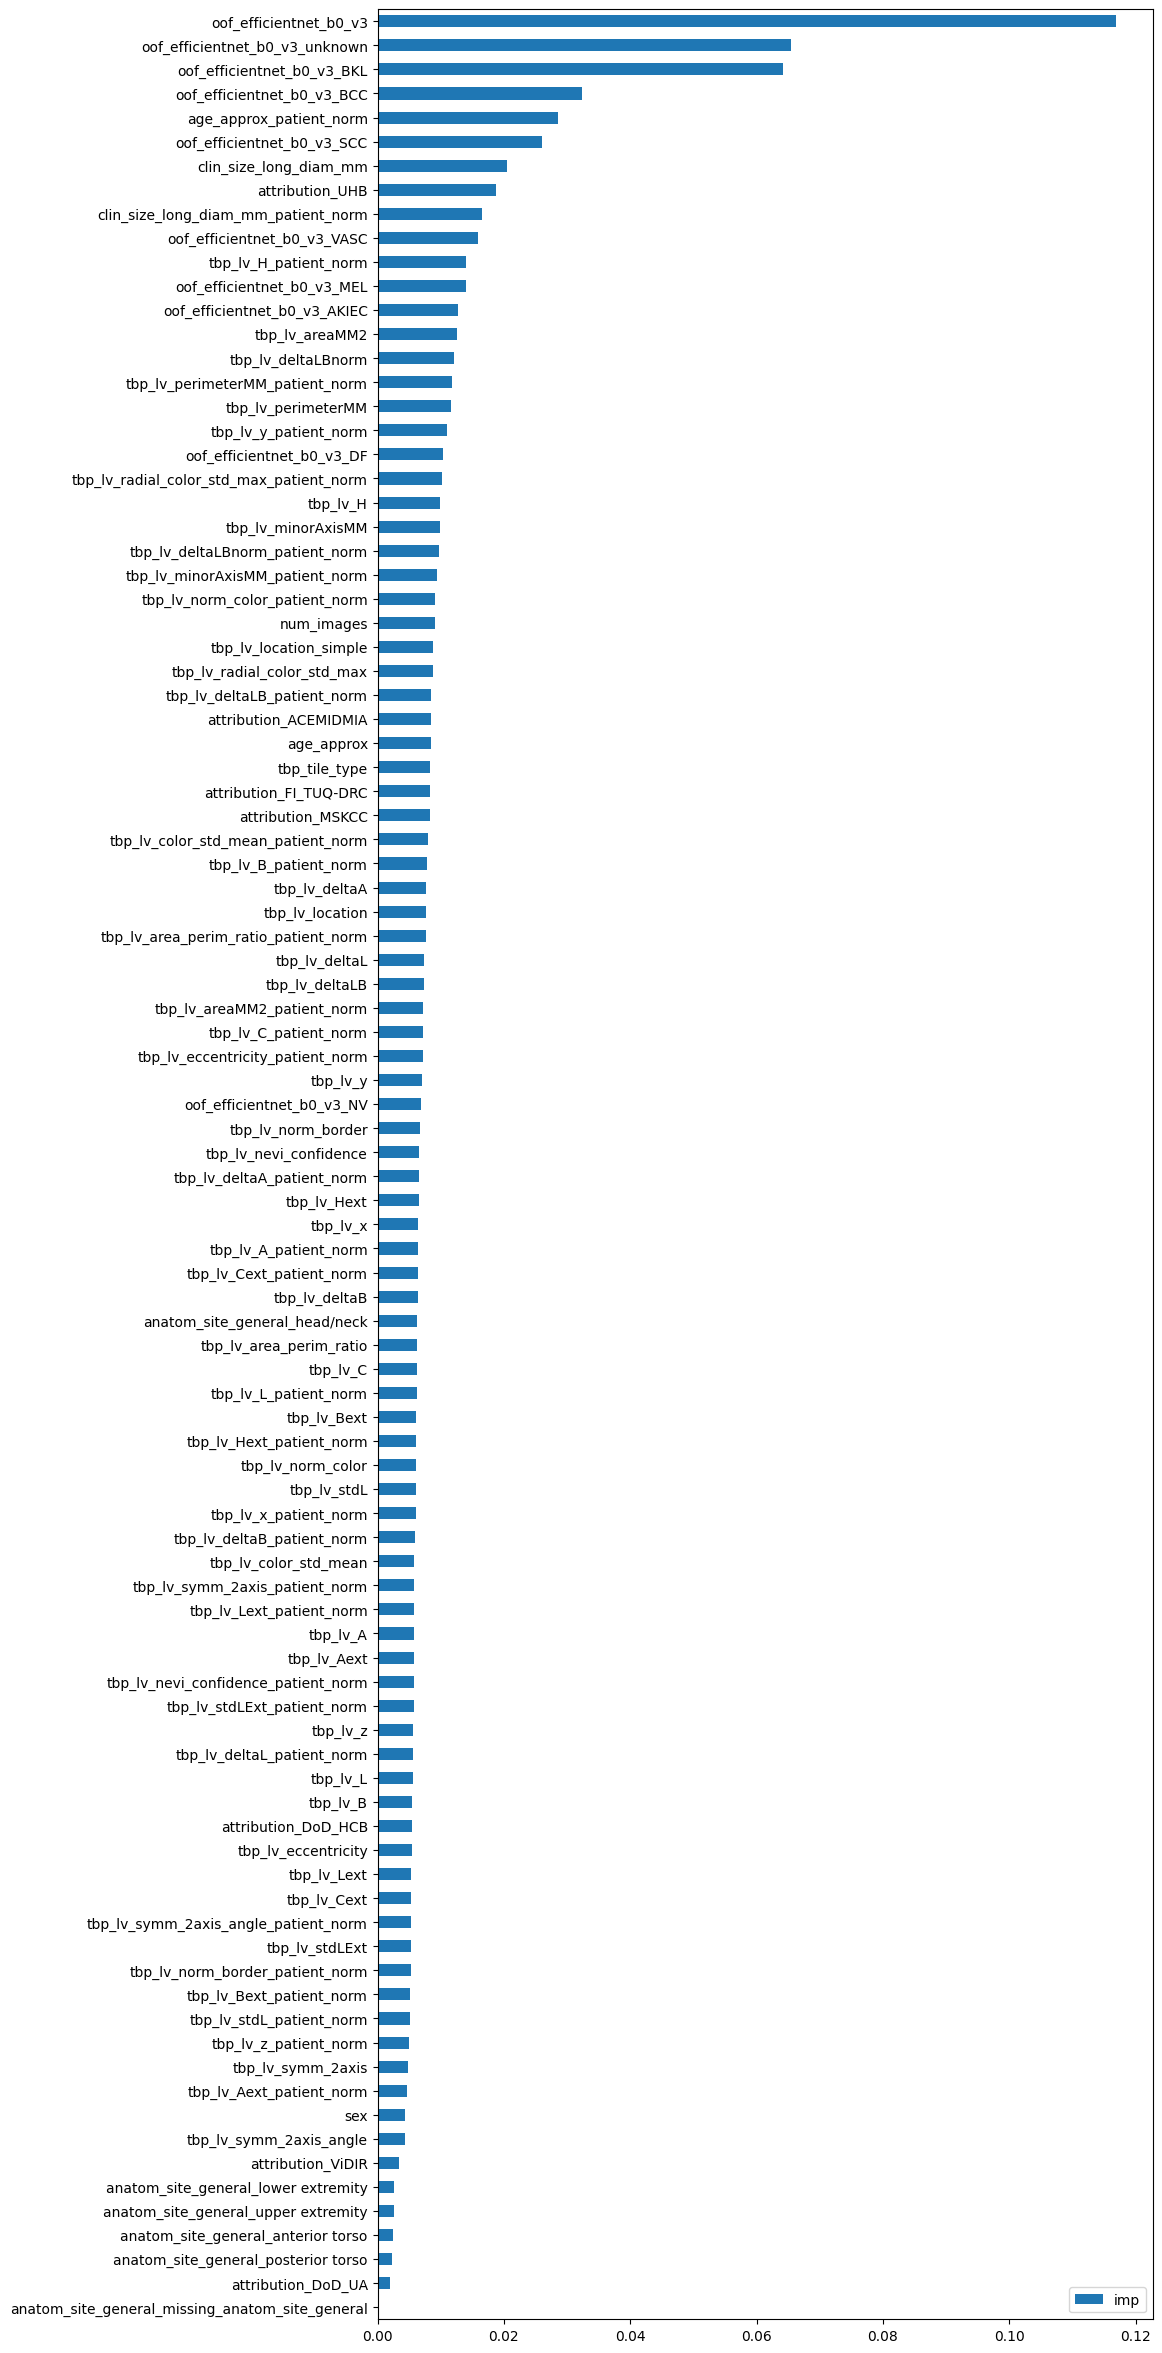

In [13]:
imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)

%matplotlib inline
imp.plot(kind="barh", figsize=(10, 30))
plt.show() 

In [14]:
metadata = {
    "config": cfg.__dict__,
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg,
    "cv_auc_std": cv_auc_std,
    "cv_pauc_std": cv_pauc_std
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)

In [15]:
metadata

{'config': {'_temp': False,
  '_key': None,
  '_parent': None,
  'seed': 2022,
  'models_output_dir': 'models',
  'model_name': 'xgb_v1',
  'sampling_ratio': 0.01},
 'params': {'enable_categorical': True,
  'tree_method': 'hist',
  'random_state': 2022,
  'learning_rate': 0.08501257473292347,
  'lambda': 8.879624125465703,
  'alpha': 0.6779926606782505,
  'max_depth': 6,
  'subsample': 0.6012681388711075,
  'colsample_bytree': 0.8437772277074493,
  'colsample_bylevel': 0.5476090898823716,
  'colsample_bynode': 0.9928601203635129,
  'scale_pos_weight': 3.29440313334688,
  'verbosity': 0,
  'disable_default_eval_metric': True},
 'num_rounds': 2000,
 'es_rounds': 150,
 'best_num_rounds': {'fold_1': 78,
  'fold_2': 101,
  'fold_3': 124,
  'fold_4': 120,
  'fold_5': 124},
 'val_auc_scores': {'fold_1': 0.9829925991998443,
  'fold_2': 0.9727706092295405,
  'fold_3': 0.9573356441327326,
  'fold_4': 0.978210134030525,
  'fold_5': 0.976523964805946},
 'val_pauc_scores': {'fold_1': 0.187148436873